In [1]:
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
t = transforms.Compose([transforms.ToTensor(), 
                        transforms.Lambda(lambda img: img.squeeze().reshape(784))])

t_target = lambda label: F.one_hot(torch.tensor(label), num_classes=10)

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=t, target_transform=t_target)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=t, target_transform=t_target)

In [3]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

Images batch shape: torch.Size([20, 784])
Labels batch shape: torch.Size([20, 10])


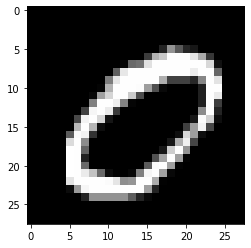

Label: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [5]:
images, labels = next(iter(train_dataloader))
print(f"Images batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0].reshape((28, 28))
label = labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [10]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z):
    ez = np.exp(z)
    sum_ez = np.sum(ez, axis=0)
    return ez / sum_ez

def softmax_prime(a, y):
    return np.sum((a-y).T * (np.diag(a.squeeze()) - np.multiply(a, a.T)), axis=1, keepdims=True)

In [11]:
def train(lr=0.1, epochs=400, print_every=20):
    W1 = np.random.uniform(low=-0.5, high=0.5, size=(64, 784))
    b1 = np.random.uniform(low=-0.5, high=0.5, size=(64, 1))
    W2 = np.random.uniform(low=-0.5, high=0.5, size=(10, 64))
    b2 = np.random.uniform(low=-0.5, high=0.5, size=(10, 1))

    costs = []
    for epoch_num in range(epochs):
        cost = 0
        for batch_num, (imgs, labels) in enumerate(train_dataloader):
            X, Y = imgs.T.numpy(), labels.T.numpy()
            m = X.shape[1]

            Z1 = np.dot(W1, X) + b1
            A1 = sigmoid(Z1)
            Z2 = np.dot(W2, A1) + b2
            A2 = softmax(Z2)
            
            cost += np.sum(np.sum((A2-Y)**2, axis=0)/2)/m

            dZ2 = []
            for i in range(m):
                a = A2[:, i].reshape((-1, 1))
                y = Y[:, i].reshape((-1, 1))
                dZ2.append(softmax_prime(a, y))
            dZ2 = np.hstack(dZ2)

            dW2 = 1/m * np.dot(dZ2, A1.T)
            db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
            dZ1 = np.dot(W2.T, dZ2) * sigmoid_prime(Z1)
            dW1 = 1/m * np.dot(dZ1, X.T)
            db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

            W1 = W1 - lr*dW1
            b1 = b1 - lr*db1
            W2 = W2 - lr*dW2
            b2 = b2 - lr*db2

        costs.append(cost)
        if (epoch_num+1) % print_every == 0 or epoch_num == 0:
            print(f"Epoch #{epoch_num+1}, Cost:{cost}")
    
    return costs, W1, b1, W2, b2

In [12]:
costs, W1, b1, W2, b2 = train()

Epoch #1, Cost:695.0526451367977
Epoch #20, Cost:107.3262424548543
Epoch #40, Cost:71.09381891092697
Epoch #60, Cost:53.01895804556013
Epoch #80, Cost:41.89106517015935
Epoch #100, Cost:34.43067223844106
Epoch #120, Cost:28.939157734396726
Epoch #140, Cost:24.7130594324255
Epoch #160, Cost:21.436902696118626
Epoch #180, Cost:18.90380808260346
Epoch #200, Cost:16.969154651194582
Epoch #220, Cost:15.434349220448423
Epoch #240, Cost:14.199803867947136
Epoch #260, Cost:13.210049527056016
Epoch #280, Cost:12.318336233794296
Epoch #300, Cost:11.585427653369832
Epoch #320, Cost:10.998712036941853
Epoch #340, Cost:10.465548225973373
Epoch #360, Cost:10.010701281346078
Epoch #380, Cost:9.551632022622492
Epoch #400, Cost:9.15439051804441


In [13]:
def predict(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    return A2

In [22]:
accuracies = []

for batch_num, (imgs, labels) in enumerate(test_dataloader):
    X, Y = imgs.T.numpy(), labels.T.numpy()
    A2 = predict(X, W1, b1, W2, b2)
    predicted_labels = A2.argmax(axis=0)
    Y = Y.argmax(axis=0)
    m = X.shape[1]
    accuracy = 1/m * (predicted_labels == Y).sum()
    accuracies.append(accuracy)

accuracies = np.array(accuracies)
print(f'Test Accuracy {accuracies.mean()}')

Test Accuracy 0.9711


In [23]:
import pickle

model = {
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2
}

with open('model', 'wb') as fout:
    pickle.dump(model, fout)

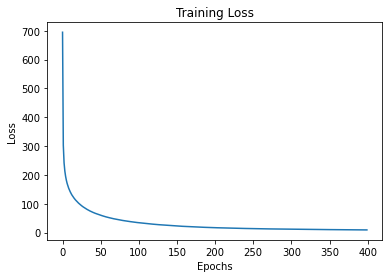

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(costs)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss');

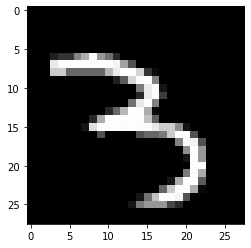

Label: 3
Predicted label: 3


In [91]:
test_range_idx = range(len(test_dataset))
idx = np.random.choice(test_range_idx)
test_img, test_label = test_dataset[idx]
test_img = test_img.numpy().reshape(-1, 1)
prediction = predict(test_img, W1, b1, W2, b2)
plt.imshow(test_img.reshape((28,28)), cmap="gray")
plt.show()
print(f"Label: {test_label.argmax()}")
print(f"Predicted label: {prediction.argmax()}")